# Depression and Anxiety classification visualization

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [1]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score


import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

## Load data

In [236]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_freq_results_29_03.pkl")
results_dep_frn_df = pd.read_pickle("data/depression_frn_results_freq_29_03.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_freq_results_29_03.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_frn_freq_results_29_03.pkl")

In [100]:
data_df = pd.DataFrame()

for dataset in [results_dep_rewp_df, results_dep_frn_df, results_anx_rewp_df, results_anx_frn_df]:
    for index, row in dataset.iterrows():

        metrics = ['mean_test_balanced_accuracy','mean_test_precision', 'mean_test_recall']

        for metric in metrics:
            band = 'delta' if row.pipeline_name.split("_")[3] == '0' else 'theta'
            model_name = row.pipeline_name.split("_")[0] + ' ' + band
            this_data = pd.DataFrame({
                'model': [model_name],
                'dataset': [row.pipeline_name.split("_")[1]],
                'score': [row[metric]],
                'metric': [metric],
            })

            data_df = pd.concat([data_df,this_data]) 

For violin

In [ ]:
results_dep_rewp_df = pd.read_pickle("data/depression_rewp_freq_results_29_03.pkl")
results_dep_frn_df = pd.read_pickle("data/depression_frn_results_freq_29_03.pkl")
results_anx_rewp_df = pd.read_pickle("data/anxiety_rewp_freq_results_29_03.pkl")
results_anx_frn_df = pd.read_pickle("data/anxiety_frn_freq_results_29_03.pkl")

In [250]:
rewp_depression_datasets = np.load('data/rewp_depression_dataset.npy')
frn_depression_datasets = np.load('data/frn_depression_datasets.npy')
rewp_anxiety_datasets = np.load('data/rewp_anxiety_datasets.npy')
frn_anxiety_datasets = np.load('data/frn_anxiety_datasets.npy')

In [260]:
%%capture
long_data_df = pd.DataFrame()

size = int(len(rewp_depression_datasets[0]) / 2)
print(size)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
metrics = ['balanced_accuracy','precision', 'recall']
y = np.array(size * [1] +  size * [0])

for metric in metrics:
    for band in (0,1):
        for estimator, dataset in [(results_dep_rewp_df, rewp_depression_datasets), (results_dep_frn_df,frn_depression_datasets)]:

            cv_scores = cross_val_score(estimator.iloc[band].best_model, dataset[band], y, cv=cv, scoring=metric)
            
            this_band = 'delta' if band == 0 else 'theta'
                
            model_name = estimator.iloc[band].pipeline_name.split("_")[0]
            this_data = pd.DataFrame({
                'model': [model_name] * len(cv_scores),
                'dataset': [estimator.iloc[band].pipeline_name.split("_")[1]] * len(cv_scores),
                'band': [this_band] * len(cv_scores),
                'scores': cv_scores,
                'metric': [metric] * len(cv_scores),
            })
    
            long_data_df = pd.concat([long_data_df,this_data]) 

In [261]:
long_data_df

,model,dataset,band,scores,metric
0,RewP,Depression,delta,0.475,balanced_accuracy
1,RewP,Depression,delta,0.450,balanced_accuracy
2,RewP,Depression,delta,0.675,balanced_accuracy
3,RewP,Depression,delta,0.650,balanced_accuracy
4,RewP,Depression,delta,0.525,balanced_accuracy
...,...,...,...,...,...
95,FRN,Depression,theta,1.000,recall
96,FRN,Depression,theta,1.000,recall
97,FRN,Depression,theta,1.000,recall
98,FRN,Depression,theta,1.000,recall


In [ ]:
%%capture
# data_df = pd.DataFrame()

size = int(len(rewp_anxiety_datasets[0]) / 2)
print(size)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
metrics = ['balanced_accuracy','precision', 'recall']
y = np.array(size * [1] +  size * [0])

for metric in metrics:
    for band in (0,1):
        for estimator, dataset in [(results_anx_rewp_df, rewp_anxiety_datasets), (results_anx_frn_df,frn_anxiety_datasets)]:

            cv_scores = cross_val_score(estimator.iloc[band].best_model, dataset[band], y, cv=cv, scoring=metric)
            
            this_band = 'delta' if band == 0 else 'theta'
                
            model_name = estimator.iloc[band].pipeline_name.split("_")[0]
            this_data = pd.DataFrame({
                'model': [model_name] * len(cv_scores),
                'dataset': [estimator.iloc[band].pipeline_name.split("_")[1]] * len(cv_scores),
                'band': [this_band] * len(cv_scores),
                'scores': cv_scores,
                'metric': [metric] * len(cv_scores),
            })
    
            long_data_df = pd.concat([long_data_df,this_data]) 

In [264]:
long_data_df

,model,dataset,band,scores,metric
0,RewP,Depression,delta,0.475000,balanced_accuracy
1,RewP,Depression,delta,0.450000,balanced_accuracy
2,RewP,Depression,delta,0.675000,balanced_accuracy
3,RewP,Depression,delta,0.650000,balanced_accuracy
4,RewP,Depression,delta,0.525000,balanced_accuracy
...,...,...,...,...,...
95,FRN,Anxiety,theta,0.666667,recall
96,FRN,Anxiety,theta,0.666667,recall
97,FRN,Anxiety,theta,0.666667,recall
98,FRN,Anxiety,theta,0.666667,recall


In [232]:
names_dict = {
    'mean_test_balanced_accuracy': 'ACC',
    'mean_test_precision': 'precision',
    'mean_test_roc_auc': 'ROC',
    'mean_test_recall': 'recall',
}

In [265]:
long_names_dict = {
    'balanced_accuracy': 'ACC',
}

In [266]:
data_df['metric'] = data_df['metric'].replace(names_dict)
long_data_df['metric'] = long_data_df['metric'].replace(long_names_dict)

In [234]:
data_df

,model,dataset,band,score,metric
0,RewP,Depression,delta,0.611111,ACC
0,RewP,Depression,delta,0.612698,precision
0,RewP,Depression,delta,0.644444,recall
0,RewP,Depression,theta,0.655556,ACC
0,RewP,Depression,theta,0.662048,precision
0,RewP,Depression,theta,0.666667,recall
0,FRN,Depression,delta,0.611111,ACC
0,FRN,Depression,delta,0.603178,precision
0,FRN,Depression,delta,0.711111,recall
0,FRN,Depression,theta,0.611111,ACC


### Visualize results

In [137]:
import matplotlib.lines as lines

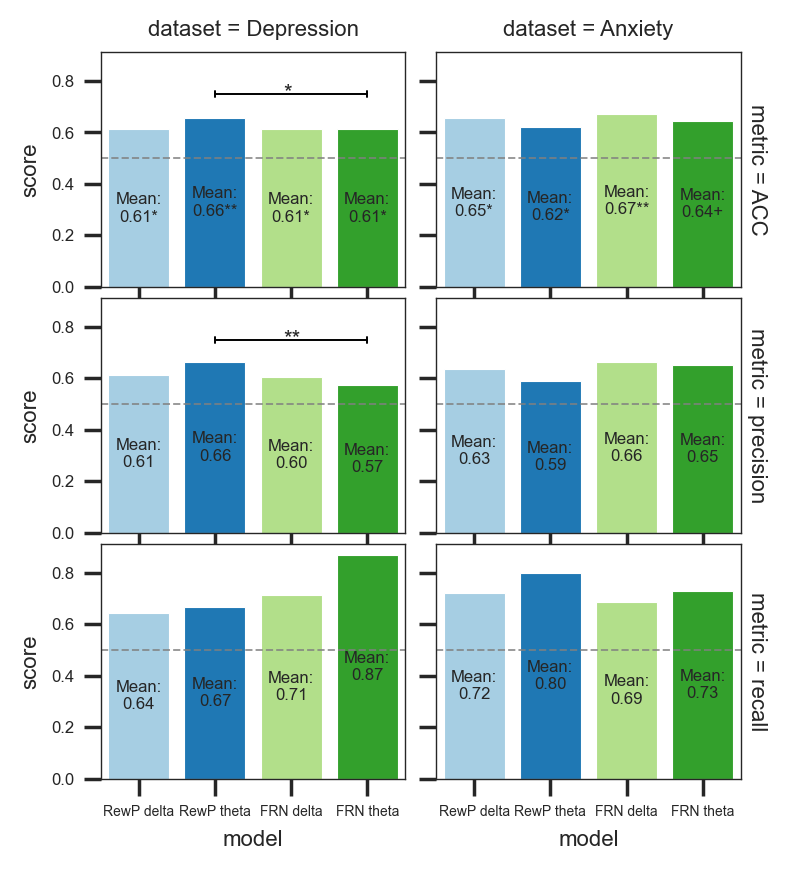

In [215]:
cm = 1/2.54
dpi = 200

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rc('font', size=6)

sns.set_palette('Paired')


sns.set_style("ticks")

g = sns.FacetGrid(
    data_df, 
    col="dataset", 
    row='metric', 
    margin_titles=True,
    # palette = 'dark',
    despine=False,
    sharex = True,
    hue='model',
    aspect=1.3
)

g.map(
    sns.barplot,
    'model',
    'score',
    order=['RewP delta', 'RewP theta', 'FRN delta', 'FRN theta'],
    saturation=1,
    linewidth=0.4
)
g.figure.subplots_adjust(wspace=.1, hspace=.05)

axes = g.axes.flatten()

 # add vlines
axes[0].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[1].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[2].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[3].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[4].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[5].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)

# add the annotation

axes[0].bar_label(axes[0].containers[0], fmt='Mean:\n%.2f*', label_type='center')
axes[0].bar_label(axes[0].containers[1], fmt='Mean:\n%.2f**', label_type='center')
axes[0].bar_label(axes[0].containers[2], fmt='Mean:\n%.2f*', label_type='center')
axes[0].bar_label(axes[0].containers[3], fmt='Mean:\n%.2f*', label_type='center')


axes[1].bar_label(axes[1].containers[0], fmt='Mean:\n%.2f*', label_type='center')
axes[1].bar_label(axes[1].containers[1], fmt='Mean:\n%.2f*', label_type='center')
axes[1].bar_label(axes[1].containers[2], fmt='Mean:\n%.2f**', label_type='center')
axes[1].bar_label(axes[1].containers[3], fmt='Mean:\n%.2f+', label_type='center')


for ax in axes[2:]:
    ax.bar_label(ax.containers[0], fmt='Mean:\n%.2f', label_type='center')
    ax.bar_label(ax.containers[1], fmt='Mean:\n%.2f', label_type='center')
    ax.bar_label(ax.containers[2], fmt='Mean:\n%.2f', label_type='center')
    ax.bar_label(ax.containers[3], fmt='Mean:\n%.2f', label_type='center')


# for ax in axes:
#     ax.add_artist(lines.Line2D([1, 2], [0.7, 0.7], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 2], [0.8, 0.8], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 3], [0.85, 0.85], color='black', linewidth=0.7))
    
#     ax.add_artist(lines.Line2D([1, 1], [0.685, 0.71], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([2, 2], [0.685, 0.71], color='black', linewidth=0.7))

#     ax.add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

        
#     ax.add_artist(lines.Line2D([2, 2], [0.787, 0.81], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 0], [0.787, 0.81], color='black', linewidth=0.7))
    
#     ax.add_artist(lines.Line2D([0, 0], [0.835, 0.86], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([3, 3], [0.835, 0.86], color='black', linewidth=0.7))
    
# add significance markers
# ACC
# axes[0].add_artist(lines.Line2D([1, 2], [0.7, 0.7], color='black', linewidth=0.7))
axes[0].add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))

# axes[0].add_artist(lines.Line2D([1, 1], [0.685, 0.71], color='black', linewidth=0.7))
# axes[0].add_artist(lines.Line2D([2, 2], [0.685, 0.71], color='black', linewidth=0.7))

axes[0].add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
axes[0].add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

# axes[0].text(1.45, 0.7, '+', fontsize=6)
axes[0].text(1.9, 0.73, '*', fontsize=8)

# precision
axes[2].add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))

axes[2].add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
axes[2].add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

axes[2].text(1.9, 0.73, '**', fontsize=8)

#recall


fig = g.fig
fig.set_size_inches(9*cm, 10*cm)

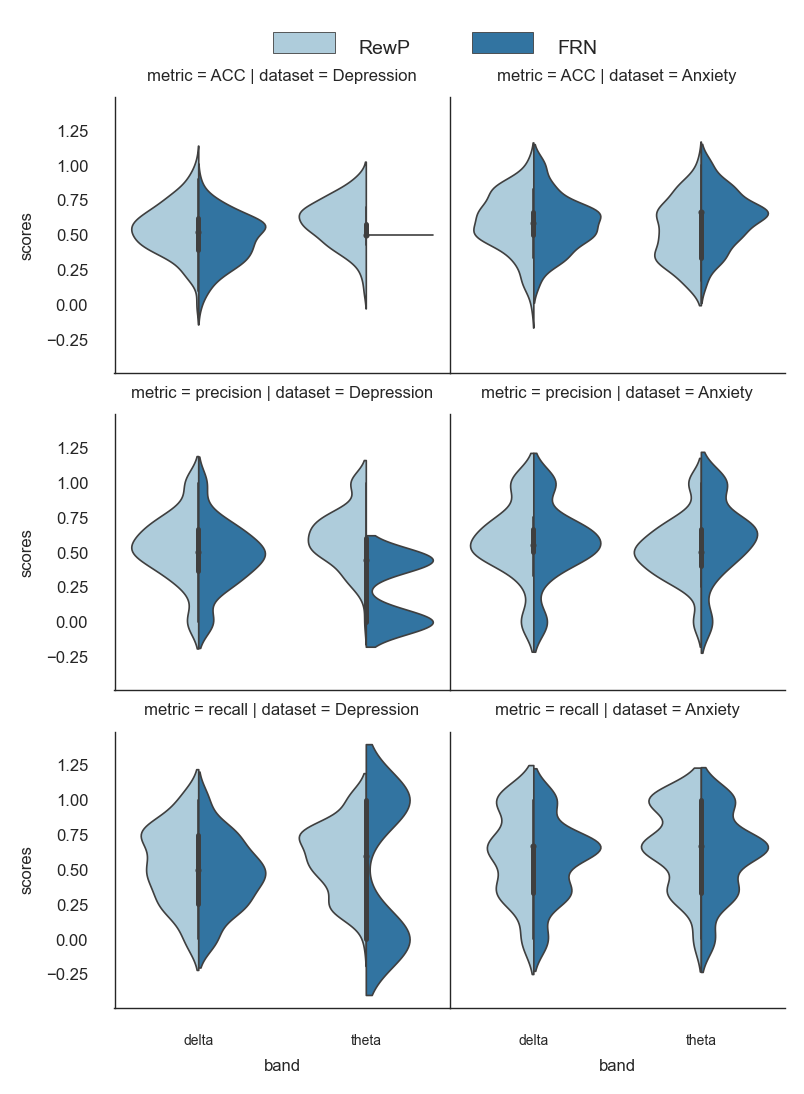

In [326]:
cm = 1/2.54
dpi = 200

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rc('font', size=6)

sns.set_palette('Paired')
sns.set_style("white")

g = sns.catplot(
    x='band', 
    y='scores', 
    hue='model',
    row='metric', 
    col='dataset', 
    data=long_data_df, 
    kind='violin', 
    height=6,
    split = True,
    despine = False,
    legend_out = False,
    linewidth = 0.6
)

g.figure.subplots_adjust(wspace=.0, hspace=.15)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

plt.setp(g._legend.get_texts(), fontsize=7)

fig = g.fig
fig.set_size_inches(9*cm, 12*cm)

### Plot features

Plot CSP components for:
- RewP depression
- FRN depression
- RewP anxiety
- FRN anxiety

In [327]:
datasets = [rewp_depression_datasets, frn_depression_datasets, rewp_anxiety_datasets, frn_anxiety_datasets]

In [ ]:
# plot CSP patterns estimated on full data for visualization
epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_types(eeg=True)
# epochs_train = anx_epochs[0]['bad'].copy().crop(tmin=tmin, tmax=tmax).pick_channels(['P1', 'P2', 'P4', 'P3', 'CP3', 'CP4', 'CP1', 'CP2', 'Pz', 'CPz',])

epochs_train.info

csp.fit_transform(evoked_data, y)

fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Plot theta & delta 

In [2]:
data = pd.read_csv('data/q_data.csv')

In [3]:
data['disorder'] = 0
for i in range(len(data)):
    if data['BDI'][i] != '#NULL!' and data['BDI'][i] >= 13:
        data['disorder'][i] = 1
    else:
        data['disorder'][i] = 0

/tmp/ipykernel_4807/1494664159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 0
/tmp/ipykernel_4807/1494664159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disorder'][i] = 1


In [4]:
data

,id,SCID,SCID_note,sex,age,BDI,BDI_cog,BDI_aff,BDI_som,TAI,...,loconf_rt,pos_rt,neg_rt,hiconf_pos_rt,loconf_pos_rt,hiconf_neg_rt,loconf_neg_rt,TST_aG,TST_aL,disorder
0,507,99.0,NaN,1,19,0.0,0.00,0.00,0.00,23.0,...,753.41,722.02,828.73,728.22,721.10,905.28,785.73,0.12,0.00,0
1,508,99.0,NaN,1,18,4.0,0.00,0.67,0.17,47.0,...,932.63,772.36,986.75,771.20,896.43,1202.03,968.84,0.28,0.93,0
2,509,99.0,NaN,1,18,7.0,0.17,0.00,0.67,44.0,...,739.20,739.28,830.53,794.16,736.67,830.53,741.74,0.07,0.05,0
3,510,99.0,NaN,1,19,1.0,0.00,0.00,0.17,27.0,...,1239.09,1231.04,1500.54,1113.41,1123.20,1035.47,1354.97,0.37,0.63,0
4,511,99.0,NaN,2,22,1.0,0.00,0.00,0.17,23.0,...,1527.80,1908.43,1305.88,1885.73,1731.81,1297.05,1323.80,0.95,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,624,1.0,NaN,1,20,23.0,1.33,1.00,0.67,60.0,...,696.15,685.56,799.69,764.35,645.86,843.43,746.44,0.65,0.81,1
117,625,2.0,subsyndromal current,1,19,16.0,0.67,1.00,0.83,60.0,...,1149.39,1130.02,1153.62,1159.48,1116.37,1139.42,1182.42,0.69,1.00,1
118,626,1.0,NaN,1,18,14.0,0.33,1.00,0.83,41.0,...,1805.77,1878.83,1732.71,1071.52,1878.83,1780.84,1732.71,0.70,0.38,1
119,627,2.0,NaN,2,19,30.0,1.00,1.33,2.17,47.0,...,2131.00,2065.05,2270.20,2167.89,1941.75,2261.39,2320.25,0.10,0.61,1


In [5]:
ids = data['id'][:].astype(int)

## Load EEG data

In [6]:
ctrl_dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] <= 13 and data['TAI'][part] > 28]
ctrl_dep = pd.DataFrame(ctrl_dep)
len(ctrl_dep)

47

In [7]:
ctrl_dep['BDI'].to_numpy()

array([ 4.,  7.,  5.,  5.,  1.,  6.,  0.,  1.,  3.,  2.,  0.,  1.,  1.,
        1.,  1.,  1.,  5.,  2.,  2.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,
        5.,  2.,  3.,  2.,  4.,  1.,  1.,  2.,  4.,  5.,  0.,  1.,  4.,
        3.,  3.,  3.,  0.,  1., 13.,  1.,  1.])

In [8]:
dep = [data.iloc[part] for part in range(len(data)) if data['BDI'][part] > 13.0 and data['TAI'][part] > 28]
dep = pd.DataFrame(dep)
len(dep)

45

In [9]:
anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] > 32) and (data['BDI'][part] <= 13)] # tai > 30
anx = pd.DataFrame(anx)
len(anx)

32

In [10]:
ctrl_anx = [data.iloc[part] for part in range(len(data)) if data['TAI'][part] < 29 and data['BDI'][part] <= 13] # tai < 30
ctrl_anx = pd.DataFrame(ctrl_anx)
len(ctrl_anx)

29

In [11]:
# dep jak oryginalnie, anx tak, żeby bdi <7

In [12]:
anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] > 31) and (data['BDI'][part] < 7)]
anx = pd.DataFrame(anx)
len(anx)

31

In [13]:
anx = anx[(anx['id'] != 599) & (anx['id'] != 600)]
len(anx)

29

In [14]:
ctrl_anx = [data.iloc[part] for part in range(len(data)) if (data['TAI'][part] < 29) and (data['BDI'][part] < 7)]
ctrl_anx = pd.DataFrame(ctrl_anx)
len(ctrl_anx)

29

In [15]:
def read_epochs(arr, group):
    for i in range(len(group)):
        fname = str(int(group.values[i, 0])) + "-epo.fif"
        print("\n\n" + fname)
        # this one doesn't exist
        if fname == "599-epo.fif" or fname == "600-epo.fif":
            continue
        arr.append(mne.read_epochs('data/' + fname))

In [16]:
%%capture

dep_epochs = []
read_epochs(dep_epochs, dep)

In [17]:
len(dep_epochs)

45

In [18]:
%%capture

ctrl_dep_epochs = []
read_epochs(ctrl_dep_epochs, ctrl_dep)

In [19]:
len(ctrl_dep_epochs)

45

In [20]:
%%capture

anx_epochs = []
read_epochs(anx_epochs, anx)

In [21]:
len(anx_epochs)

29

In [22]:
%%capture

ctrl_anx_epochs = []
read_epochs(ctrl_anx_epochs, ctrl_anx)

In [23]:
len(ctrl_anx_epochs)

29

In [24]:
freq_ranges = [(0.0,3.5), (4.0,9.0)]
freq_ranges

[(0.0, 3.5), (4.0, 9.0)]

## Visualize depressed vs control brain activity

In [25]:
%%capture

freq_data = []

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Apply band-pass filter to isolate the specified frequencies
    epoch_dep_filtered = [epoch.copy().filter(fmin, fmax, fir_design='firwin',
                                   skip_by_annotation='edge') for epoch in dep_epochs]
    
    epoch_dep_ctr_filtered = [epoch.copy().filter(fmin, fmax, fir_design='firwin',
                                   skip_by_annotation='edge') for epoch in ctrl_dep_epochs]


    freq_data.append((epoch_dep_filtered, epoch_dep_ctr_filtered))

In [26]:
dep_delta_data = freq_data[0]
dep_theta_data = freq_data[1]

In [75]:
depression_epochs = mne.concatenate_epochs(dep_epochs)
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep_epochs)

Not setting metadata
10027 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
8952 matching events found
Applying baseline correction (mode: mean)


In [77]:
evokeds_dep = [depression_epochs.copy()[name].average().crop(0.1, 0.4) for name in ('good', 'bad')]
evokeds_dep_ctr = [depression_ctr_epochs.copy()[name].average().crop(0.1, 0.4) for name in ('good', 'bad')]

dep_spectrum = [evoked.compute_psd() for evoked in evokeds_dep]
dep_ctr_spectrum = [evoked.compute_psd() for evoked in evokeds_dep_ctr]

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [78]:
rewp_delta_contrast = dep_spectrum[0].get_data(fmin=0.05, fmax=3.5) - dep_ctr_spectrum[0].get_data(fmin=0.05, fmax=3.5)
rewp_theta_contrast = dep_spectrum[0].get_data(fmin=4, fmax=8) - dep_ctr_spectrum[0].get_data(fmin=4, fmax=8)

frn_delta_contrast = dep_spectrum[1].get_data(fmin=0.05, fmax=3.5) - dep_ctr_spectrum[1].get_data(fmin=0.05, fmax=3.5)
frn_theta_contrast = dep_spectrum[1].get_data(fmin=4, fmax=8) - dep_ctr_spectrum[1].get_data(fmin=4, fmax=8)

### Delta

In [327]:
depression_epochs = mne.concatenate_epochs(dep_delta_data[0])
depression__ctr_epochs = mne.concatenate_epochs(dep_delta_data[1])

Not setting metadata
10027 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
8952 matching events found
Applying baseline correction (mode: mean)


In [328]:
evokeds_dep = [depression_epochs[name].average() for name in ('good', 'bad')]
evokeds_dep_ctr = [depression__ctr_epochs[name].average() for name in ('good', 'bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

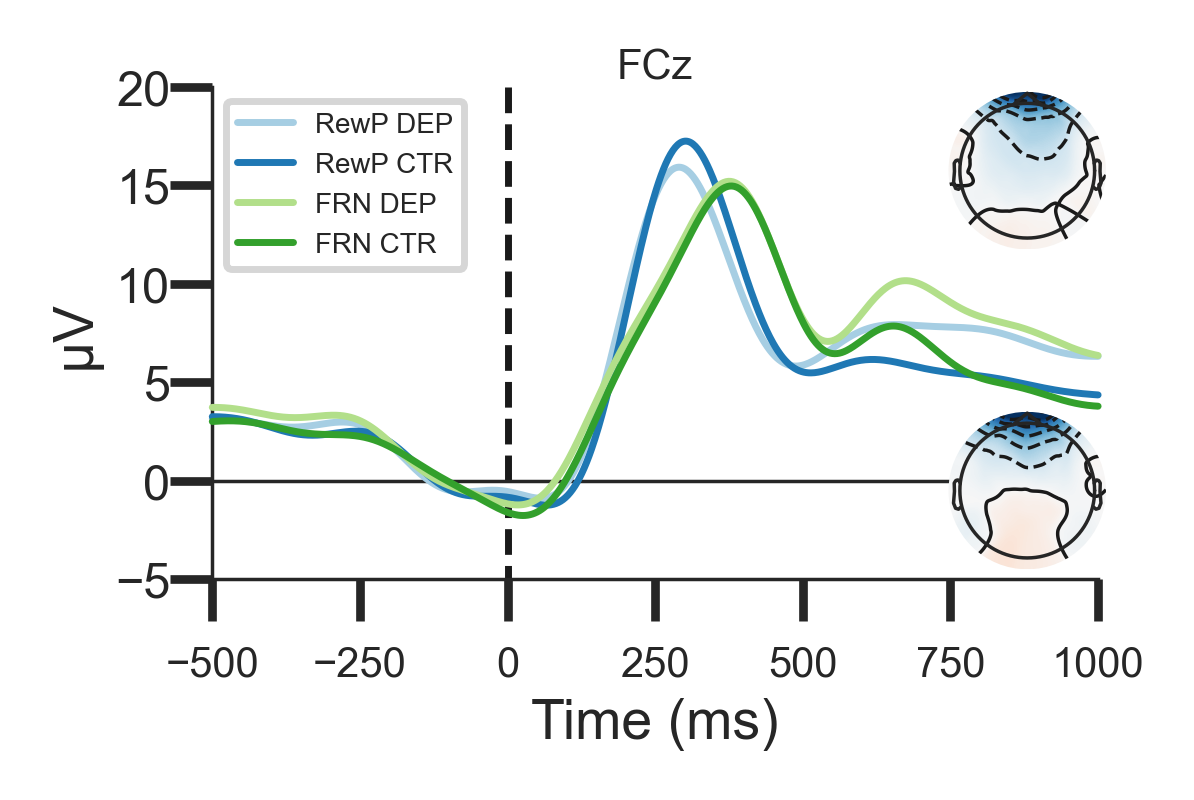

In [329]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


rewp_fig, rewP_cont = mne.viz.plot_topomap(
    rewp_delta_contrast.reshape(-1), 
    evokeds_dep[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_rewP_axis
)
plt.setp(rewP_cont.collections , linewidth=0.5)
plt.setp(topo_rewP_axis.lines , linewidth=0.5)


frn_fig, frn_cont = mne.viz.plot_topomap(
    frn_delta_contrast.reshape(-1), 
    evokeds_dep[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_FRN_axis
)
plt.setp(frn_cont.collections , linewidth=0.5)
plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-5, 20]),
    axes=ax,
    time_unit='ms',
)


fig.savefig(f'data/delta_dep', bbox_inches='tight', pad_inches=0.01)

### Theta

In [330]:
depression_epochs = mne.concatenate_epochs(dep_theta_data[0])
depression__ctr_epochs = mne.concatenate_epochs(dep_theta_data[1])

Not setting metadata
10027 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
8952 matching events found
Applying baseline correction (mode: mean)


In [331]:
evokeds_dep = [depression_epochs[name].average() for name in ('good', 'bad')]
evokeds_dep_ctr = [depression__ctr_epochs[name].average() for name in ('good', 'bad')]

evokeds = {
    'RewP DEP': evokeds_dep[0],
    'RewP CTR': evokeds_dep_ctr[0],
    'FRN DEP' : evokeds_dep[1],
    'FRN CTR' : evokeds_dep_ctr[1],
}

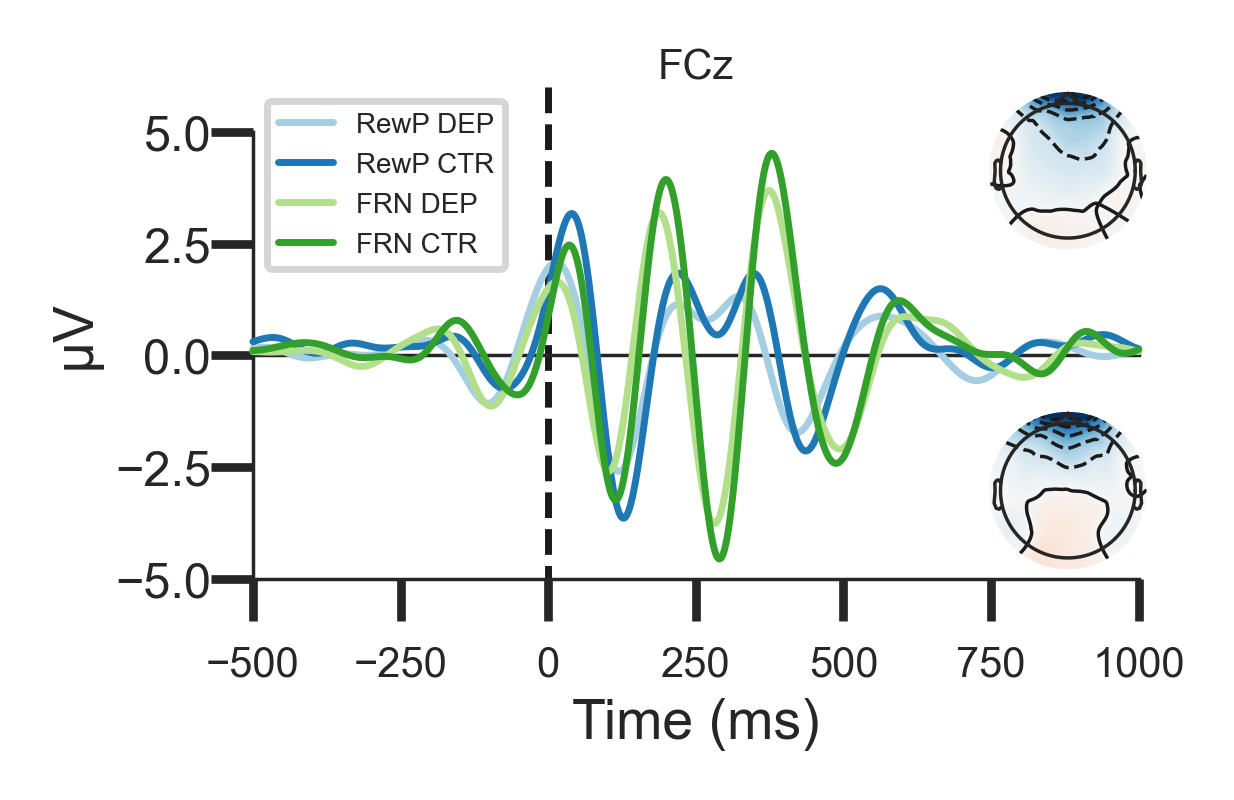

In [334]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


rewp_fig, rewP_cont = mne.viz.plot_topomap(
    rewp_delta_contrast.reshape(-1), 
    evokeds_dep[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_rewP_axis
)
plt.setp(rewP_cont.collections , linewidth=0.5)
plt.setp(topo_rewP_axis.lines , linewidth=0.5)


frn_fig, frn_cont = mne.viz.plot_topomap(
    frn_delta_contrast.reshape(-1), 
    evokeds_dep[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_FRN_axis
)
plt.setp(frn_cont.collections , linewidth=0.5)
plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-5, 6]),
    axes=ax,
    time_unit='ms',
)


fig.savefig(f'data/theta_dep', bbox_inches='tight', pad_inches=0.01)

## Visualize anxiety vs control brain activity

In [335]:
%%capture

freq_data = []

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Apply band-pass filter to isolate the specified frequencies
    epoch_anx_filtered = [epoch.copy().filter(fmin, fmax, fir_design='firwin',
                                   skip_by_annotation='edge') for epoch in anx_epochs]
    
    epoch_anx_ctr_filtered = [epoch.copy().filter(fmin, fmax, fir_design='firwin',
                                   skip_by_annotation='edge') for epoch in ctrl_anx_epochs]


    freq_data.append((epoch_anx_filtered, epoch_anx_ctr_filtered))

In [336]:
anx_delta_data = freq_data[0]
anx_theta_data = freq_data[1]

In [337]:
anxiety_epochs = mne.concatenate_epochs(anx_epochs)
anxiety_ctr_epochs = mne.concatenate_epochs(ctrl_anx_epochs)

Not setting metadata
5805 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
6149 matching events found
Applying baseline correction (mode: mean)


In [338]:
evokeds_anx = [anxiety_epochs.copy()[name].average().crop(0.1, 0.4) for name in ('good', 'bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs.copy()[name].average().crop(0.1, 0.4) for name in ('good', 'bad')]

anx_spectrum = [evoked.compute_psd() for evoked in evokeds_anx]
anx_ctr_spectrum = [evoked.compute_psd() for evoked in evokeds_anx_ctr]

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [339]:
rewp_delta_contrast = anx_spectrum[0].get_data(fmin=0.05, fmax=3.5) - anx_ctr_spectrum[0].get_data(fmin=0.05, fmax=3.5)
rewp_theta_contrast = anx_spectrum[0].get_data(fmin=4, fmax=8) - anx_ctr_spectrum[0].get_data(fmin=4, fmax=8)

frn_delta_contrast = anx_spectrum[1].get_data(fmin=0.05, fmax=3.5) - anx_ctr_spectrum[1].get_data(fmin=0.05, fmax=3.5)
frn_theta_contrast = anx_spectrum[1].get_data(fmin=4, fmax=8) - anx_ctr_spectrum[1].get_data(fmin=4, fmax=8)

### Delta

In [340]:
anxiety_epochs = mne.concatenate_epochs(anx_delta_data[0])
anxiety_ctr_epochs = mne.concatenate_epochs(anx_delta_data[1])

Not setting metadata
5805 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
6149 matching events found
Applying baseline correction (mode: mean)


In [341]:
evokeds_anx = [anxiety_epochs[name].average() for name in ('good', 'bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs[name].average() for name in ('good', 'bad')]

evokeds = {
    'RewP ANX': evokeds_anx[0],
    'RewP CTR': evokeds_anx_ctr[0],
    'FRN ANX' : evokeds_anx[1],
    'FRN CTR' : evokeds_anx_ctr[1],
}

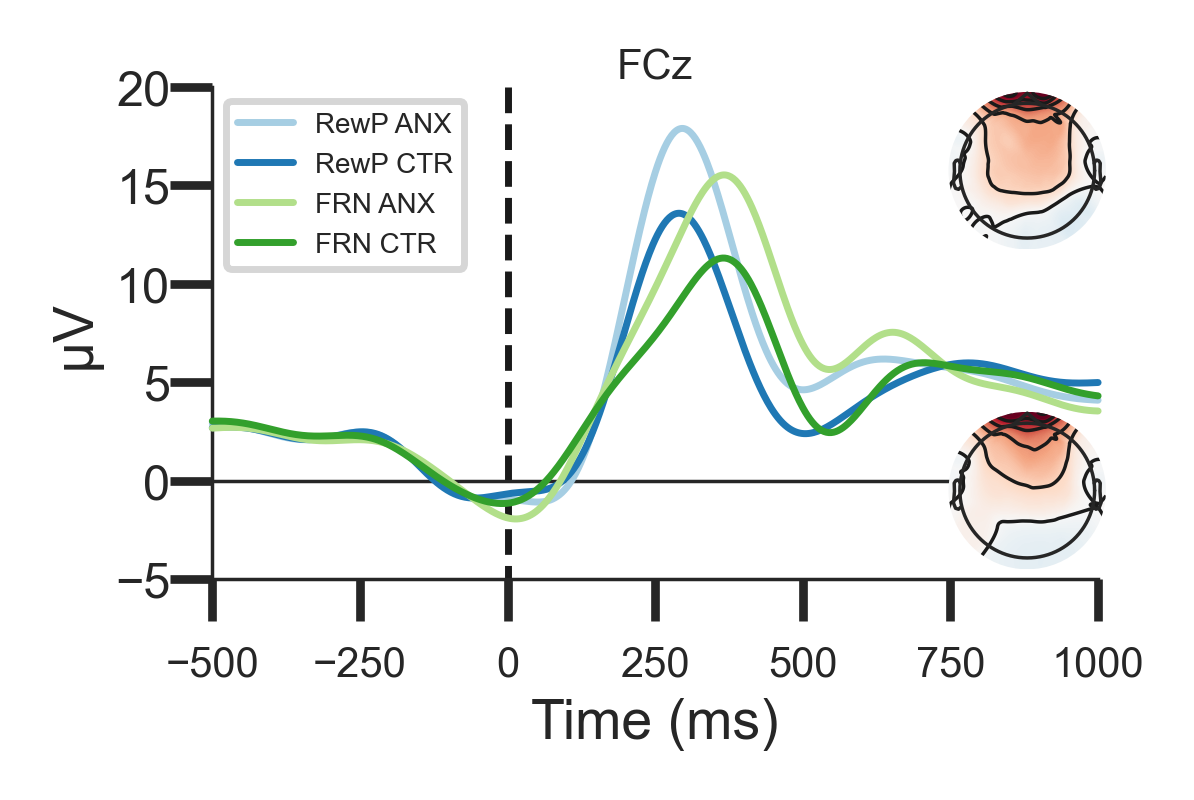

In [342]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


rewp_fig, rewP_cont = mne.viz.plot_topomap(
    rewp_delta_contrast.reshape(-1), 
    evokeds_anx[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_rewP_axis
)
plt.setp(rewP_cont.collections , linewidth=0.5)
plt.setp(topo_rewP_axis.lines , linewidth=0.5)


frn_fig, frn_cont = mne.viz.plot_topomap(
    frn_delta_contrast.reshape(-1), 
    evokeds_anx[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_FRN_axis
)
plt.setp(frn_cont.collections , linewidth=0.5)
plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-5, 20]),
    axes=ax,
    time_unit='ms',
)


fig.savefig(f'data/delta_anx', bbox_inches='tight', pad_inches=0.01)

### Theta

In [343]:
anxiety_epochs = mne.concatenate_epochs(anx_theta_data[0])
anxiety_ctr_epochs = mne.concatenate_epochs(anx_theta_data[1])

Not setting metadata
5805 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
6149 matching events found
Applying baseline correction (mode: mean)


In [344]:
evokeds_anx = [anxiety_epochs[name].average() for name in ('good', 'bad')]
evokeds_anx_ctr = [anxiety_ctr_epochs[name].average() for name in ('good', 'bad')]

evokeds = {
    'RewP ANX': evokeds_anx[0],
    'RewP CTR': evokeds_anx_ctr[0],
    'FRN ANX' : evokeds_anx[1],
    'FRN CTR' : evokeds_anx_ctr[1],
}

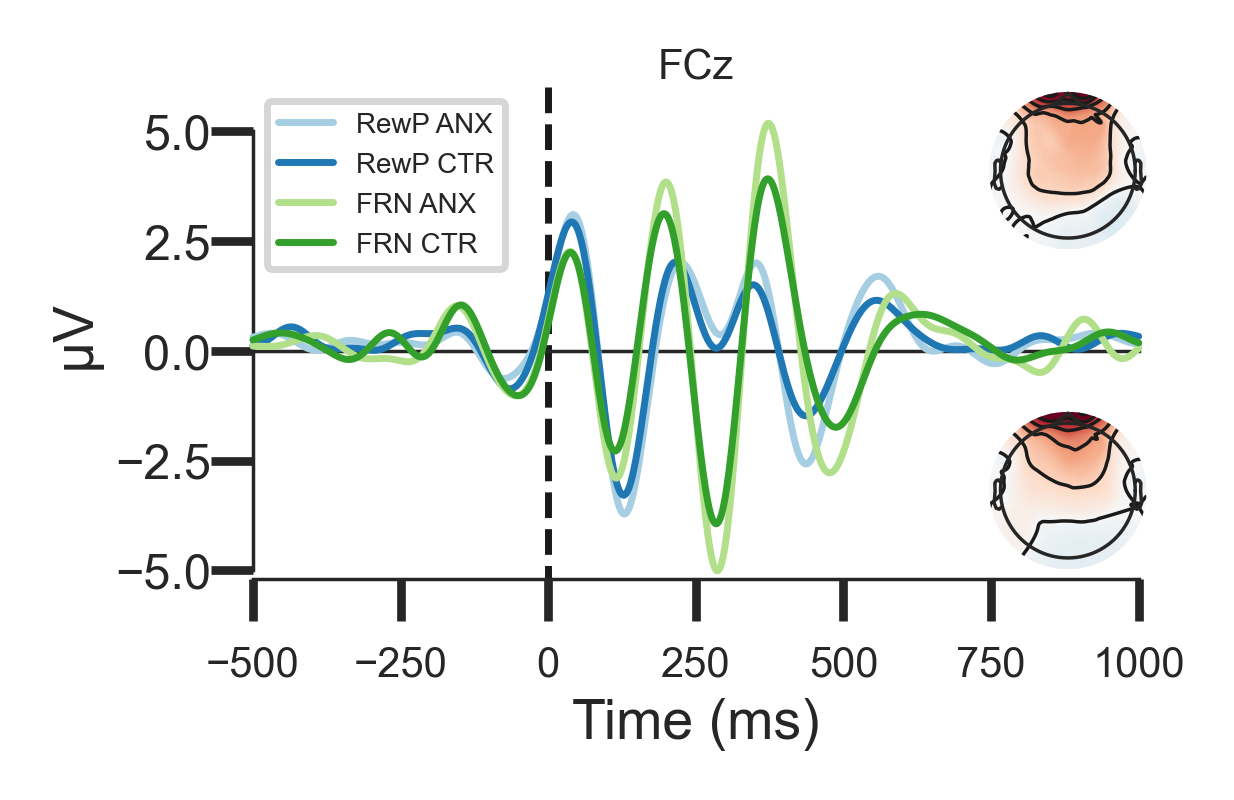

In [346]:
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")


plt.rcParams['figure.dpi'] = dpi
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2



sns.set_palette('Paired')

picks = ["FCz"]

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(4.5*cm, 2.5*cm))

ax = fig.add_axes([0,0,1,1], zorder=-1)
topo_rewP_axis = fig.add_axes([0.76,0.67,0.32,0.32], zorder=1000)
topo_FRN_axis = fig.add_axes([0.76,0.02,0.32,0.32], zorder=10000)


rewp_fig, rewP_cont = mne.viz.plot_topomap(
    rewp_delta_contrast.reshape(-1), 
    evokeds_anx[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_rewP_axis
)
plt.setp(rewP_cont.collections , linewidth=0.5)
plt.setp(topo_rewP_axis.lines , linewidth=0.5)


frn_fig, frn_cont = mne.viz.plot_topomap(
    frn_delta_contrast.reshape(-1), 
    evokeds_anx[0].info, 
    show=False, 
    res=1000, 
    sensors=False,
    axes=topo_FRN_axis
)
plt.setp(frn_cont.collections , linewidth=0.5)
plt.setp(topo_FRN_axis.lines , linewidth=0.5)



a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-5.2, 6]),
    axes=ax,
    time_unit='ms',
)


fig.savefig(f'data/theta_anx', bbox_inches='tight', pad_inches=0.01)